<a href="https://colab.research.google.com/github/jackkyboy/AAPL-AMZN-GOOG-Price2018-2020/blob/main/Predicted_LE_vs_Health_Expenditure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
import pandas as pd

focus_countries = ["AUS","CAN","DEU","FRA","GBR","JPN","KOR","THA","USA"]

# ------------------------------
# 1) โหลด Health Expenditure (%GDP)
# ------------------------------
exp_raw = pd.read_csv("oecd_health_exp_gdp.csv")

exp = exp_raw[
    (exp_raw["MEASURE"] == "EXP_HEALTH") &
    (exp_raw["UNIT_MEASURE"] == "PT_B1GQ") &
    exp_raw["OBS_VALUE"].notna()
][["REF_AREA", "TIME_PERIOD", "OBS_VALUE"]]

exp = exp.rename(columns={
    "REF_AREA": "country",
    "TIME_PERIOD": "year",
    "OBS_VALUE": "health_exp_pct_gdp"
})

exp["year"] = pd.to_numeric(exp["year"], errors="coerce").astype("Int64")
exp["health_exp_pct_gdp"] = pd.to_numeric(exp["health_exp_pct_gdp"], errors="coerce")
exp = exp[exp["country"].isin(focus_countries)]

# ------------------------------
# 2) โหลด Life Expectancy
# ------------------------------
life_raw = pd.read_csv("HEALTH_LIFEEXP_01012025.csv")

life = life_raw[["REF_AREA", "TIME_PERIOD", "SEX", "OBS_VALUE"]].rename(columns={
    "REF_AREA": "country",
    "TIME_PERIOD": "year",
    "OBS_VALUE": "life_expectancy"
})

life["year"] = pd.to_numeric(life["year"], errors="coerce").astype("Int64")
life["life_expectancy"] = pd.to_numeric(life["life_expectancy"], errors="coerce")
life = life[life["country"].isin(focus_countries)]

# ------------------------------
# 3) เลือก SEX อย่างถูกต้อง (_T > F/M > one)
# ------------------------------
def pick_sex_group(g: pd.DataFrame) -> pd.Series:
    if "_T" in g["SEX"].values:
        return g[g["SEX"] == "_T"].iloc[0]
    elif set(g["SEX"].values) >= {"F", "M"}:
        idx = g["life_expectancy"].astype(float).idxmax()
        return g.loc[idx]
    else:
        return g.iloc[0]

life_clean = (
    life.groupby(["country", "year"], group_keys=False)
        .apply(pick_sex_group)
        .reset_index(drop=True)
)

# ------------------------------
# 4) Merge exp + life
# ------------------------------
merged = exp.merge(
    life_clean[["country","year","SEX","life_expectancy"]],
    on=["country","year"],
    how="left"
)

merged = merged.sort_values(["country","year"])

# ------------------------------
# 5) เติมค่าปีล่าสุดแบบ LOCF
# ------------------------------
merged["life_expectancy"] = (
    merged.groupby("country")["life_expectancy"]
          .ffill()
)

# ------------------------------
# 6) คำนวณ HES
# ------------------------------
merged["HES"] = merged["life_expectancy"] / merged["health_exp_pct_gdp"]

# ------------------------------
# 7) เซฟไฟล์ให้นำไปใช้ในงานวิจัยชุดใหม่
# ------------------------------
merged.to_csv("health_efficiency_panel.csv", index=False)

merged.head(20)

/tmp/ipython-input-29111060.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_sex_group)


,country,year,health_exp_pct_gdp,SEX,life_expectancy,HES
63,AUS,2014,9.828,_T,82.3,8.374033
64,AUS,2015,10.136,_T,82.4,8.129440
65,AUS,2016,10.090,_T,82.4,8.166501
66,AUS,2017,10.109,_T,82.5,8.161045
67,AUS,2018,10.089,_T,82.8,8.206958
68,AUS,2019,10.254,_T,82.9,8.084650
69,AUS,2020,10.703,_T,83.2,7.773521
70,AUS,2021,10.516,_T,83.3,7.921263
71,AUS,2022,9.892,_T,83.2,8.410837
2,AUS,2023,9.884,_T,83.0,8.397410


In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

panel = merged.copy()

# log transform
panel["ln_health_exp"] = np.log(panel["health_exp_pct_gdp"])

# covid dummy
panel["covid_dummy"] = panel["year"].isin([2020, 2021]).astype(int)

# time trend
panel["year_trend"] = panel["year"] - panel["year"].min()

panel = panel.dropna(subset=["life_expectancy"])

In [4]:
X1 = sm.add_constant(panel["ln_health_exp"])
y  = panel["life_expectancy"]

model1 = sm.OLS(y, X1).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     7.883
Date:                Mon, 01 Dec 2025   Prob (F-statistic):            0.00605
Time:                        16:27:06   Log-Likelihood:                -215.21
No. Observations:                  98   AIC:                             434.4
Df Residuals:                      96   BIC:                             439.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            77.3066      1.439     53.741

In [7]:
print("=== X2_clean.dtypes ===")
print(X2_clean.dtypes)

print("\n=== y_clean.dtype ===")
print(y_clean.dtype)

=== X2_clean.dtypes ===
ln_health_exp    float64
covid_dummy        int64
year_trend         Int64
C_CAN               bool
C_DEU               bool
C_FRA               bool
C_GBR               bool
C_JPN               bool
C_KOR               bool
C_THA               bool
C_USA               bool
dtype: object

=== y_clean.dtype ===
float64


In [8]:
import numpy as np
import statsmodels.api as sm

# 1) บังคับทุกคอลัมน์ใน X2_clean ให้เป็น float
X2_num = X2_clean.astype(float)

# 2) y ให้เป็น float เช่นกัน (กันชัวร์)
y_num = y_clean.astype(float)

# 3) เติม constant
X2_const = sm.add_constant(X2_num, has_constant="add")

# 4) ฟิตโมเดล
model2 = sm.OLS(y_num, X2_const).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     195.1
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           7.31e-56
Time:                        16:31:32   Log-Likelihood:                -59.515
No. Observations:                  98   AIC:                             143.0
Df Residuals:                      86   BIC:                             174.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            83.6082      2.147     38.946

In [9]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     195.1
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           7.31e-56
Time:                        16:31:43   Log-Likelihood:                -59.515
No. Observations:                  98   AIC:                             143.0
Df Residuals:                      86   BIC:                             174.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            83.6082      2.147     38.946

In [11]:
def predict_le(country, year, he_pct_gdp, model, panel):

    ln_he = np.log(he_pct_gdp)
    covid_dummy = int(year in [2020, 2021])
    year_trend = year - panel["year"].min()

    # เตรียมอินพุต
    data = {
        "ln_health_exp": ln_he,
        "covid_dummy": covid_dummy,
        "year_trend": year_trend,
    }

    # สร้าง dummy country
    for col in [c for c in model.params.index if c.startswith("C_")]:
        data[col] = 0

    base = panel["country"].sort_values().unique()[0]
    if country != base:
        cname = f"C_{country}"
        if cname in data:
            data[cname] = 1

    X = pd.DataFrame([data])
    X = sm.add_constant(X, has_constant="add")

    return model.predict(X)[0]

In [12]:
le_tha_2025 = predict_le("THA", 2025, 5.0, model2, panel)
print("Predicted LE THA 2025 ~", le_tha_2025)

Predicted LE THA 2025 ~ 76.82669609300703


In [13]:
for he in [4.5, 5.0, 6.0]:
    le = predict_le("THA", 2025, he, model2, panel)
    print(f"THA, 2025, HE={he}% GDP → LE ≈ {le:.2f} ปี")

THA, 2025, HE=4.5% GDP → LE ≈ 76.87 ปี
THA, 2025, HE=5.0% GDP → LE ≈ 76.83 ปี
THA, 2025, HE=6.0% GDP → LE ≈ 76.76 ปี


In [14]:
country_dummies = pd.get_dummies(panel["country"], prefix="C", drop_first=True)

X2 = pd.concat(
    [panel[["ln_health_exp", "covid_dummy", "year_trend"]], country_dummies],
    axis=1
)

X2_num = X2.astype(float)
y_num  = panel["life_expectancy"].astype(float)

X2_const = sm.add_constant(X2_num, has_constant="add")
model2 = sm.OLS(y_num, X2_const).fit()

In [15]:
import pandas as pd
import numpy as np

countries = ["THA", "KOR", "JPN"]
he_values = [4.5, 5.0, 6.0]  # % ของ GDP
year = 2025

rows = []

for c in countries:
    for he in he_values:
        le_pred = predict_le(c, year, he, model2, panel)
        rows.append({
            "country": c,
            "year": year,
            "health_exp_pct_gdp": he,
            "predicted_LE": le_pred
        })

sim_df = pd.DataFrame(rows)

# ปัดทศนิยมให้อ่านง่าย
sim_df["predicted_LE_round"] = sim_df["predicted_LE"].round(2)

print(sim_df)

  country  year  health_exp_pct_gdp  predicted_LE  predicted_LE_round
0     THA  2025                 4.5     76.865973               76.87
1     THA  2025                 5.0     76.826696               76.83
2     THA  2025                 6.0     76.758730               76.76
3     KOR  2025                 4.5     83.192833               83.19
4     KOR  2025                 5.0     83.153556               83.15
5     KOR  2025                 6.0     83.085589               83.09
6     JPN  2025                 4.5     84.628599               84.63
7     JPN  2025                 5.0     84.589322               84.59
8     JPN  2025                 6.0     84.521356               84.52


In [16]:
sim_pivot = sim_df.pivot(
    index="health_exp_pct_gdp",
    columns="country",
    values="predicted_LE_round"
)

print(sim_pivot)

country               JPN    KOR    THA
health_exp_pct_gdp                     
4.5                 84.63  83.19  76.87
5.0                 84.59  83.15  76.83
6.0                 84.52  83.09  76.76


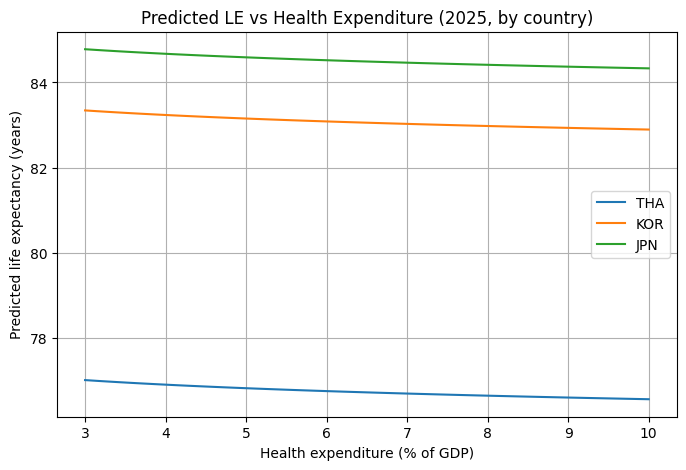

In [17]:
import matplotlib.pyplot as plt
import numpy as np

he_grid = np.linspace(3.0, 10.0, 50)  # งบสุขภาพ 3% → 10% ของ GDP
year = 2025
countries = ["THA", "KOR", "JPN"]

plt.figure(figsize=(8, 5))

for c in countries:
    preds = [predict_le(c, year, he, model2, panel) for he in he_grid]
    plt.plot(he_grid, preds, label=c)

plt.xlabel("Health expenditure (% of GDP)")
plt.ylabel("Predicted life expectancy (years)")
plt.title("Predicted LE vs Health Expenditure (2025, by country)")
plt.legend()
plt.grid(True)
plt.show()